# MACD + RSI + BBW Strategy for BTC/USDT (1hr)

## Import Modules and Data

In [2]:
# To run this code, you will have to install pandas, pandas_ta, backtesting, plotly, scipy 
# if you are using pip or pip3, you can run the following commands in your terminal:
!pip3 install backtesting
!pip3 install pandas_ta
!pip3 install plotly
!pip3 install scipy
!pip3 install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas_ta as ta
from scipy import stats
import numpy as np
from datetime import datetime
from backtesting import Strategy
from backtesting import Backtest
from scipy.stats import linregress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=816953227c0c9448f898f9eeb2b76ec34f0f4537f58278b0a119507f4638d6ed
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=213bbb0bf539abf6380b5bd2a5cb29bbd92fb788602e2a8e8ef4573b6a5f91e3
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


/opt/conda/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
import pandas as pd
import numpy as np

In [52]:
#Preprocessing data
def preprocess_data(file_path:str):
    df = pd.read_csv( file_path, index_col='datetime', parse_dates=True)
    df.dropna(inplace=True)
    df.rename(columns={'open' : "Open" , 'close' : 'Close' , 'high' : 'High' ,'low' : 'Low' , 'volume' : 'Volume' } , inplace=True)
    return df

# The current strategy uses 1hr time frame data
# file_path = '/kaggle/input/btcusdt2018-22/BTC_23_1h.csv' #Replace this with path of file containing btcusdt_1h data
file_path = '/kaggle/input/btcusdt2018-22/btc_18_22_1h.csv' #Replace this with path of file containing btcusdt_1h data
btc_1h_data = preprocess_data(file_path)

## Functions to generate Indicators

In [109]:
#Function to calculate exponential moving average
def calculate_exponential_moving_average(df:pd.DataFrame, window:int, column_name:str='Close'):
    df_copy = df.copy()
    ema = df_copy[column_name].ewm(span=window, adjust=False).mean()
    df_copy[f'ema_{window}'] = ema
    return df_copy[f'ema_{window}']

#Function to calculate Moving Average Convergence Divergence Indicator
def calculate_moving_average_convergence_divergence(df: pd.DataFrame, slow_window: int = 16, fast_window: int = 8, signal_window: int = 4):
    df_copy = df.copy()
    exponential_moving_average_16 = calculate_exponential_moving_average(df_copy, slow_window)
    exponential_moving_average_8 = calculate_exponential_moving_average(df_copy, fast_window)
    macd = exponential_moving_average_8 - exponential_moving_average_16
    df_copy['macd'] = macd
    signal = calculate_exponential_moving_average(df_copy, signal_window, column_name='macd')
    df_copy['signal_line'] = signal
    return df_copy['macd'], df_copy['signal_line']

#Function to calculate Volume Condtion
def calculate_volume_condition(df: pd.DataFrame,slow_window: int = 20, fast_window: int = 10  ):
    """
    Calculates the volume condition for a given DataFrame.
    Volume condition - Tells us whether the 10 period SMA is above the 50 period SMA or not
    Used for confirmation of the upward or the downward trend of the price action

    """
    df_copy = df.copy()
    df_copy[f'sma_{slow_window}'] = df_copy['Close'].rolling(slow_window).mean()
    df_copy[f'sma_{fast_window}'] = df_copy['Close'].rolling(fast_window).mean()
    df_copy['vol_condition'] =[df_copy[f'sma_{fast_window}'][i] > df_copy[f'sma_{slow_window}'][i] for i in range(len(df_copy[f'sma_{slow_window}']))]
    return df_copy['vol_condition']

#Function to calculate RSI
def calculate_relative_strength_index(df:pd.DataFrame, window:int=14):
    df_copy = df.copy()
    rsi = ta.rsi(df_copy['Close'], length=window)
    return rsi

#Function to calculate Bollinger Bands
def calculate_bollinger_bands_width_condition(df: pd.DataFrame, window: int = 20, n1:int=10, n2:int=20):
    df_copy = df.copy()
    df_copy[f'sma_{window}'] = df['Close'].rolling(window).mean()
    df_copy[f'std_{window}'] = df['Close'].rolling(window).std()
    df_copy['upper_band'] = df_copy[f'sma_{window}'] + 2 * df_copy[f'std_{window}']
    df_copy['lower_band'] = df_copy[f'sma_{window}'] - 2 * df_copy[f'std_{window}']
    df_copy['bb_width'] = (df_copy['upper_band'] - df_copy['lower_band']) / df_copy[f'sma_{window}']
    # n1 < n2
    df_copy['bbw_condition'] =df_copy['bb_width'].rolling(n1).mean() > df_copy['bb_width'].rolling(n2).mean() 
    return df_copy['bbw_condition']

#Function to calculate weighted moving average
def calculate_weighted_moving_average(df: pd.DataFrame, window: int = 14):
    df_copy = df.copy()
    df_copy['wma'] = df_copy.ewm(alpha=1/window, adjust=False).mean()
    return df_copy['wma']

#Function to calculate Average True Range
def calculate_average_true_range(df: pd.DataFrame, window: int = 14):
    """
    Calculates the Average True Range (ATR) for a given DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the high, low, and close prices.
    - window (int): The window size for calculating the ATR. Default is 14.

    Returns:
    - pd.Series: The calculated Average True Range values.
    """
    df_copy = df.copy()
    high = df_copy['High']
    low = df_copy['Low']
    close = df_copy['Close']
    df_copy['arg_0'] = abs(high - low)
    df_copy['arg_1'] = abs(high - close.shift())
    df_copy['arg_2'] = abs(low - close.shift())
    args = df_copy[['arg_0', 'arg_1', 'arg_2']].max(axis=1)
    df_copy['average_true_range'] = calculate_weighted_moving_average(args, window)
    return df_copy['average_true_range']

def calculate_average_directional_index(df:pd.DataFrame , window:int = 14):
    df_copy = df.copy()
    df_copy['up'] = df_copy['High'] - df_copy['High'].shift()
    df_copy['down'] = df_copy['Low'].shift() - df_copy['Low']
    df_copy['plus_dm'] = np.where((df_copy['up']>df_copy['down']) & (df_copy['up']>0), df_copy['up'], 0)
    df_copy['minus_dm'] = np.where((df_copy['down']>df_copy['up']) & (df_copy['down']>0), df_copy['down'], 0)
    df_copy['plus_dm_avg'] = calculate_weighted_moving_average(df_copy['plus_dm'], window)
    df_copy['minus_dm_avg'] = calculate_weighted_moving_average(df_copy['minus_dm'], window)
    df_copy['atr'] = calculate_average_true_range(df_copy)
    df_copy['plus_di'] = 100 * (df_copy['plus_dm_avg']/df_copy['atr'])
    df_copy['minus_di'] = 100 * (df_copy['minus_dm_avg']/df_copy['atr'])
    df_copy['adx'] = 100 * (abs(df_copy['plus_di'] - df_copy['minus_di'])/(df_copy['plus_di'] + df_copy['minus_di']))
    return df_copy['adx']



## Initialize data frame with indicators


In [110]:
# btc_1h_data['MACD'] , btc_1h_data['Signal_line'] = calculate_moving_average_convergence_divergence(btc_1h_data)
# btc_1h_data['EMA_200'] = calculate_exponential_moving_average(btc_1h_data ,window = 200 )
# btc_1h_data['Volume_Condition'] = calculate_volume_condition(btc_1h_data)
# btc_1h_data['RSI'] = calculate_relative_strength_index(btc_1h_data)
# btc_1h_data['BBW_Condition'] = calculate_bollinger_bands_width_condition(btc_1h_data)
# btc_1h_data['Average_True_Range'] = calculate_average_true_range(btc_1h_data)
# btc_1h_data['Average_Directional_Index'] = calculate_average_directional_index(btc_1h_data)

## Creating preliminary signals(without stop loss and take profit)

In [117]:
#Generate Signals
signal = [0]*len(btc_1h_data)

for i in range(200,len(btc_1h_data)) :
    # generate the signals here
    pass

btc_1h_data['signal'] = signal

## Initial Backtest using stop loss and take profit

In [118]:
#Function to calculate the stoploss and takeprofit
#fs implies future signal 
def get_stoploss_takeprofit(fs:int, vol_cond:bool, volatility: int):
    # function to get stop loss and take profit levels or to dynamically update them
        

In [154]:
btc_2022 = btc_1h_data[(43680*2)//5-42:]
btc_2022

,Open,High,Low,Close,Volume,MACD,Signal_line,EMA_200,Volume_Condition,RSI,BBW_Condition,Average_True_Range,Average_Directional_Index,macd_crossover,macd_crossdown,check_RSI,volatility,volatility50,signal
datetime,,,,,,,,,,,,,,,,,,,
2020-01-01 05:30:00,7195.24,7196.25,7175.46,7177.02,511.814901,-13.530013,-14.846774,7263.891212,False,36.401367,False,33.317684,11.443123,False,False,True,0.275015,0.403281,0
2020-01-01 06:30:00,7176.47,7230.00,7175.71,7216.27,883.052603,-9.189465,-12.583850,7263.417369,False,48.491107,False,34.815706,6.399213,False,False,True,0.325813,0.400119,0
2020-01-01 07:30:00,7215.52,7244.87,7211.41,7242.85,655.156809,-3.190803,-8.826631,7263.212718,False,54.762547,False,34.718870,13.007688,False,False,True,0.443658,0.401896,0
2020-01-01 08:30:00,7242.66,7245.00,7220.00,7225.01,783.724867,-0.856275,-5.638489,7262.832592,False,50.332971,False,34.024665,13.065475,False,False,True,0.459115,0.404232,0
2020-01-01 09:30:00,7225.00,7230.00,7215.03,7217.27,467.812578,-0.041173,-3.399563,7262.379233,False,48.500018,False,32.663618,10.055522,False,False,True,0.436414,0.405545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 01:30:00,16525.91,16571.51,16523.91,16568.69,6253.722810,0.143355,-5.929275,16712.547316,False,52.648733,True,60.599789,28.296777,False,False,True,0.215631,0.151503,0
2022-12-31 02:30:00,16569.36,16677.35,16568.31,16585.06,8873.195050,5.281324,-1.445035,16711.278785,False,54.525141,True,64.059804,6.140517,False,False,True,0.232197,0.154797,0
2022-12-31 03:30:00,16585.06,16597.00,16577.57,16583.27,3950.193240,8.482119,2.525826,16710.005066,False,54.271885,True,60.871961,6.140517,False,False,True,0.239498,0.158254,0


In [ ]:
# Generating the finals signals based on the initial signals , involving stoploss and take profit
#fs implies future signal
# data = btc_1h_data[3*len(btc_1h_data)//4:]
data = btc_2022
class MyStrat(Strategy):
    mysize = 1 - 1e-010
    data['trade'] = 0
    data['signals'] = 0

    def init(self):
        self.fs = 0
        self.prevfs = 0
        super().init()

    def next(self):
        if self.fs == 0:
            for trade in self.trades:
                # update the stop loss and take profit levels for each trade
                # or maybe any other ways to close a trade
                # can also generate opposite signals for the next candle using the fs or future signal parameter
                pass

    # here we use the strong signals generated by the initial signals to generate the final signals
            if self.data.signal[-1] == 1 :
                if not self.position.is_long and not self.position.is_short :
                    # if no position then buy
                    pass
                if self.position.is_short:
                    # close short trade if any
                    pass

            elif self.data.signal[-1] == -1 :
                if not self.position.is_long and not self.position.is_short:
                    # if no position then sell
                    pass
                if self.position.is_long :
                    # if long trade then close
                    pass
                    
        if self.fs > 0:
            if self.data.signal[-1] == 1 :
                if not self.position.is_long and not self.position.is_short:
                    # long here if no position
                    pass
            else:
                # if some condition satisfied then long
                # set prev fs to be fs so that we can change stoploss and takeprofit according to the prevfs code
                self.prevfs = self.fs
            self.fs = 0
        elif self.fs < 0:
            if self.data.signal[-1] == -1 :
                if not self.position.is_long and not self.position.is_short:
                    # short here if no position
                    pass
            else:
                # if some condition satisfied then short
                # set prev fs to be fs so that we can change stoploss and takeprofit according to the prevfs code
                self.prevfs = self.fs
            self.fs = 0
bt = Backtest(data, MyStrat, cash=100000, commission= 0.001)
stat = bt.run()
stat

In [151]:
stat._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-2,27,48,47272.34034,47056.43,431.82068,0.004567,2022-01-02 03:30:00,2022-01-03 00:30:00,0 days 21:00:00
1,-2,118,120,46255.31838,45919.93,670.77676,0.007251,2022-01-05 22:30:00,2022-01-06 00:30:00,0 days 02:00:00
2,-2,186,190,41834.44368,41346.02,976.84736,0.011675,2022-01-08 18:30:00,2022-01-08 22:30:00,0 days 04:00:00
3,-2,221,234,41822.75538,40930.01,1785.49076,0.021346,2022-01-10 05:30:00,2022-01-10 18:30:00,0 days 13:00:00
4,-2,269,308,42686.56071,44154.52,-2935.91858,-0.034389,2022-01-12 05:30:00,2022-01-13 20:30:00,1 days 15:00:00
...,...,...,...,...,...,...,...,...,...,...
79,-6,8439,8457,16679.62368,16681.43,-10.83792,-0.000108,2022-12-18 15:30:00,2022-12-19 09:30:00,0 days 18:00:00
80,-6,8514,8516,16817.19597,16794.28,137.49582,0.001363,2022-12-21 18:30:00,2022-12-21 20:30:00,0 days 02:00:00
81,-6,8532,8540,16791.28191,16674.53,700.51146,0.006953,2022-12-22 12:30:00,2022-12-22 20:30:00,0 days 08:00:00
82,-6,8585,8612,16807.59558,16828.68,-126.50652,-0.001254,2022-12-24 17:30:00,2022-12-25 20:30:00,1 days 03:00:00


<Axes: xlabel='datetime'>

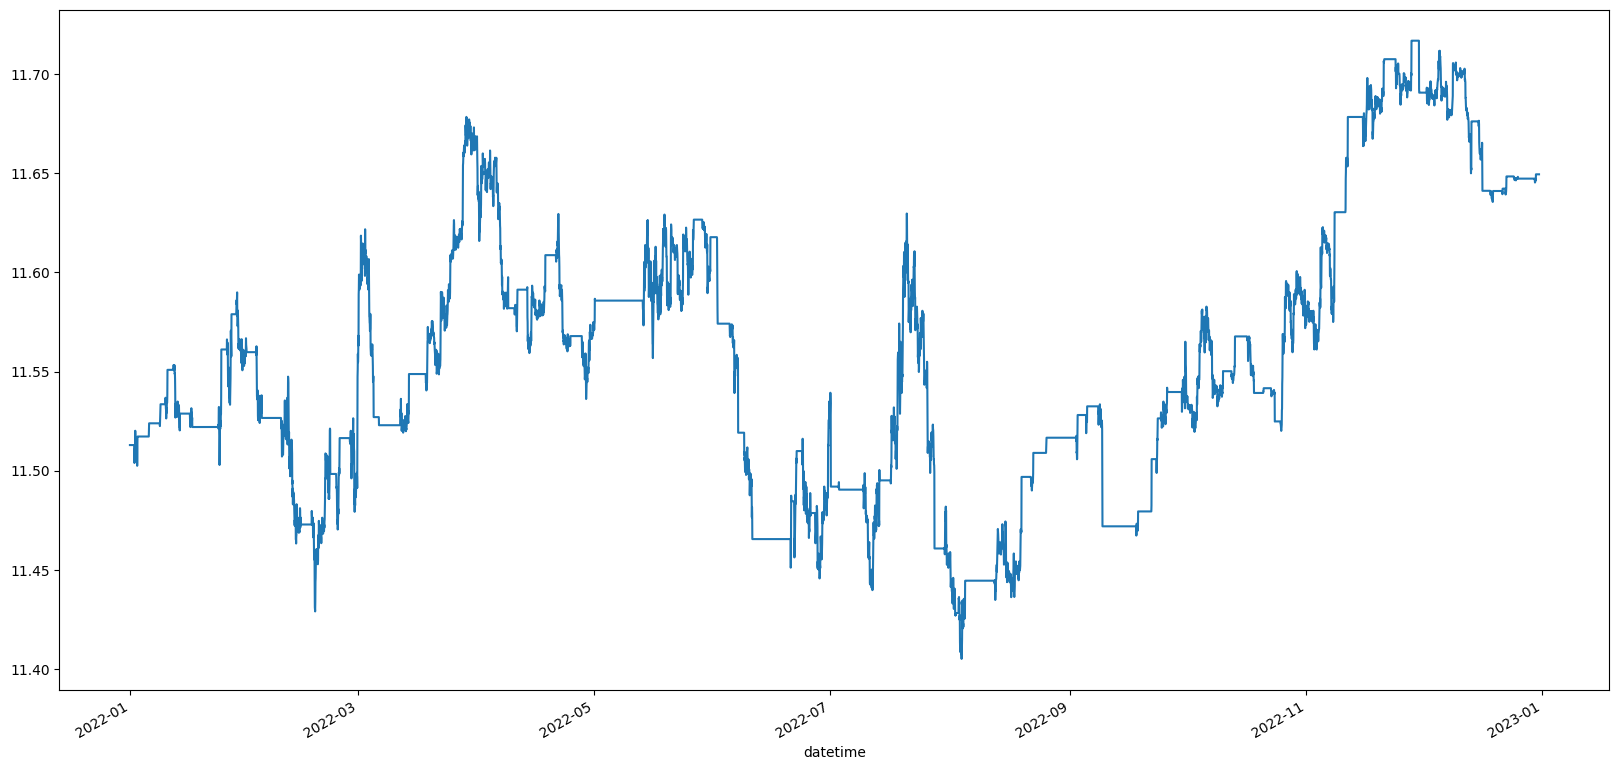

In [152]:
np.log(stat._equity_curve.Equity).plot(figsize=(20,10))

<Axes: xlabel='datetime'>

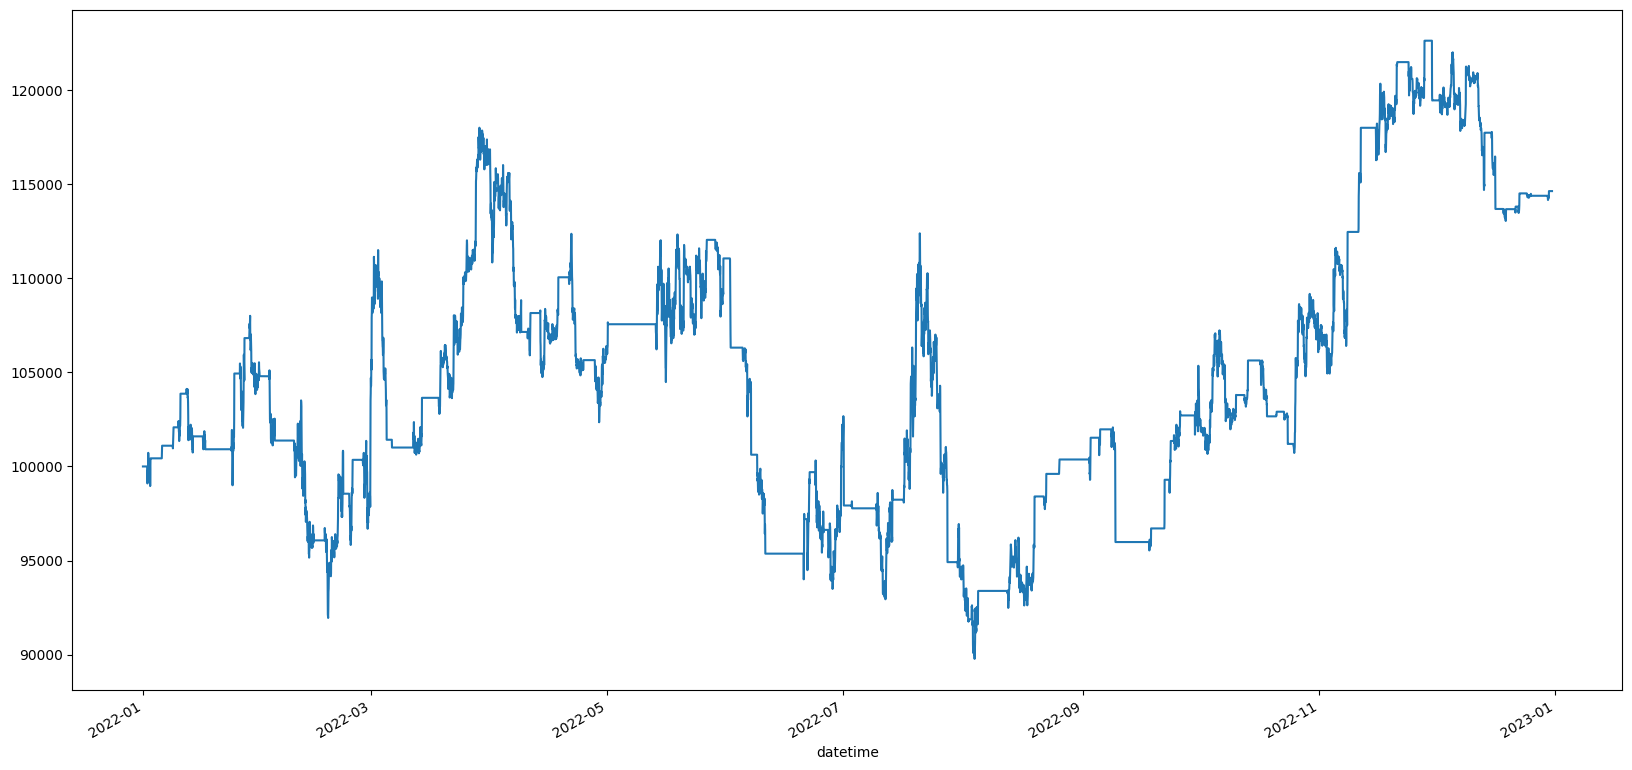

In [153]:
stat._equity_curve.Equity.plot(figsize=(20,10))

<Axes: xlabel='datetime'>

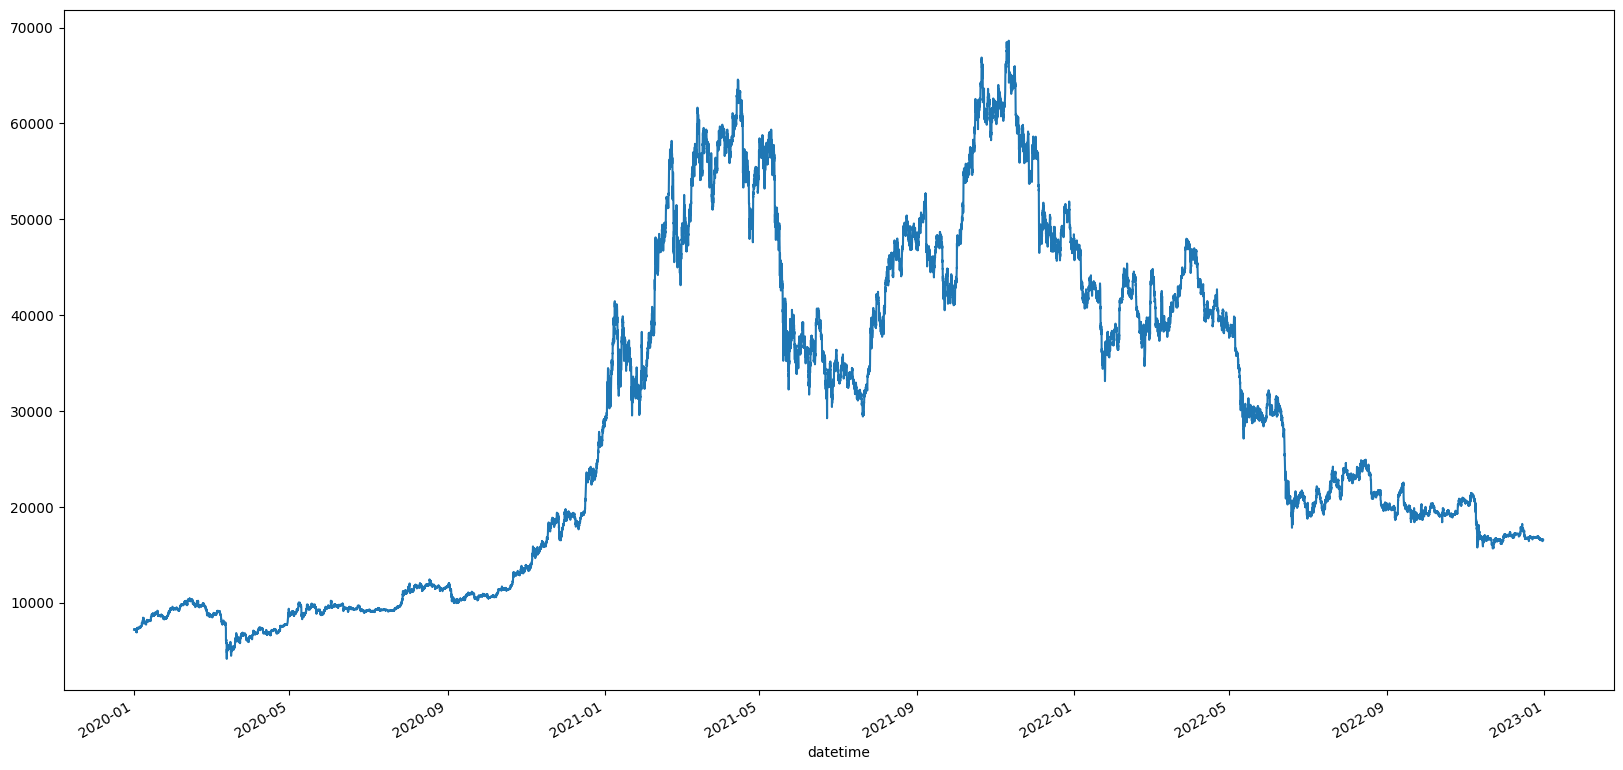

In [144]:
data['Close'].plot(figsize=(20,10))

## Create final signals and store in csv

In [24]:
#Creating the final signals using the trade logs from above
#Create a deepcopy of the dataframe 'data' to avoid any changes in the original dataframe
final = data.copy(deep=True)
trades=stat._trades

for i in range(len(trades)):
    if trades['Size'][i] > 0:
        final['signals'][trades['EntryBar'][i]-1] = 1
        final['signals'][trades['ExitBar'][i]-1] = -1
    elif trades['Size'][i] < 0:
        final['signals'][trades['EntryBar'][i]-1] = -1
        final['signals'][trades['ExitBar'][i]-1] = 1

print(len(final[final['signals'] == 1]), len(final[final['signals'] == -1]))

287 287


/tmp/ipykernel_42/1907322783.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['signals'][trades['EntryBar'][i]-1] = -1
/tmp/ipykernel_42/1907322783.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['signals'][trades['ExitBar'][i]-1] = 1
/tmp/ipykernel_42/1907322783.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['signals'][trades['EntryBar'][i]-1] = -1
/tmp/ipykernel_42/1907322783.py:12: SettingWithCopyWar

In [ ]:
# Making a final data frame
final = final.reset_index()
df_final = final[['Open' , 'Close' , 'High' , 'Low' , 'Volume' , 'signals','datetime' ]]
df_final.rename(columns={'Open' : "open" , 'Close' : 'close' , 'High' : 'high' ,'Low' : 'low' , 'Volume' : 'volume' } , inplace=True)
df_final

In [11]:
# Storing the dataframe in a csv file
df_final.to_csv('test.csv')

## Checking the finals results

In [12]:
#Backtesting on final csv file
file_path = '/home/madhu/Zelta/test.csv' #Replace this with path of file containing test data
test_data = preprocess_data(file_path)

In [ ]:
# Backtesting on the final csv file created
class check_signals(Strategy):
    mysize = 0.99999999
    def init(self):
        super().init()

    def next(self):

        if self.data.signals == 1:
            if not self.position.is_long and not self.position.is_short  :
                self.buy( size = self.mysize)

            elif self.position.is_short:
                self.position.close()

        elif self.data.signals == -1:
            if not self.position.is_long and not self.position.is_short:
                self.sell(size = self.mysize)
                
            elif self.position.is_long:
                self.position.close()

bt_check = Backtest(test_data, check_signals, cash=100000, commission= 0.001)
stats = bt_check.run()
stats

## Visualisation using graphs

In [ ]:
# Visualisation of log values of close and portfolio to compare them
fig1 = go.Figure()

# Add trace for log(close)
fig1.add_trace(go.Scatter(x=test_data.index, y=np.log(test_data.Close), name='close_log', mode='lines'))

# Add trace for log(portfolio) with actual values on the y-axis
equity_log = np.log(stats._equity_curve.Equity)
fig1.add_trace(go.Scatter(x=stats._equity_curve.Equity.index, y=equity_log, name='portfolio_log', mode='lines'))

# Set custom tick format for the y-axis
fig1.update_layout(
    yaxis=dict(
        tickvals=[np.log(value) for value in [10000,100000,1e6,1e7,1e8]],
        ticktext=[str(value) for value in [10000,100000,1e6,1e7,1e8]],  )
)

fig1.show()


In [ ]:
# The portfolio graph
fig2 =go.Figure()
fig2.add_trace(go.Scatter(x = stats._equity_curve.Equity.index , y =stats._equity_curve.Equity , name='portfolio', mode ='lines'))
fig2.show()

In [ ]:
# detailed visualisation of all the trades
# Profit -- Green
# Loss -- Red

log_c = stats._trades
fig3 =go.Figure()
fig3.add_trace(go.Scatter(x = test_data.index , y =test_data.Open , name='Open Values', mode ='lines',showlegend=False))

for i in range(0 , len(log_c)) :

    if log_c.PnL[i] > 0 :
        fig3.add_scatter(x=[log_c.EntryTime[i]  ,log_c.ExitTime[i] ], y=[log_c.EntryPrice[i], log_c.ExitPrice[i]], mode="lines",
                marker=dict(size=3, color="green"),showlegend=False)
    else :
        fig3.add_scatter(x=[log_c.EntryTime[i]  ,log_c.ExitTime[i] ], y=[log_c.EntryPrice[i], log_c.ExitPrice[i]], mode="lines",
                marker=dict(size=3, color="red"), showlegend=False)

fig3.show()